In [2]:
import warnings

warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import lal as _lal

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.noise import noise_from_string
import pycbc.noise.reproduceable
from pycbc.psd import analytical
from pycbc.waveform import get_td_waveform, get_fd_waveform

1. Simulation Parameters

In [4]:
sample_rate = 4096    # Sampling rate (Hz)
duration = 32.0       # Time series duration (seconds)
delta_t = 1.0 / sample_rate
tsamples = int(duration * sample_rate)

start_time = 0.0
end_time = duration
seed_value = 127
flow = 30.0           # Low-frequency cutoff

# Frequency Parameters
delta_f = 1.0 / duration
flen = int(sample_rate / (2 * delta_f)) + 1 

2. Noise Time Series Generation

In [5]:
# White Noise (Pure Gaussian)
ts_white = pycbc.noise.reproduceable.normal(
    start=start_time,
    end=end_time,
    sample_rate=sample_rate,
    seed=seed_value
)

# Colored Noise (aLIGO)
psd = analytical.aLIGOZeroDetHighPower(flen, delta_f, flow)
ts_colored = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=seed_value)

3. Noise Visualization (Time Domain)

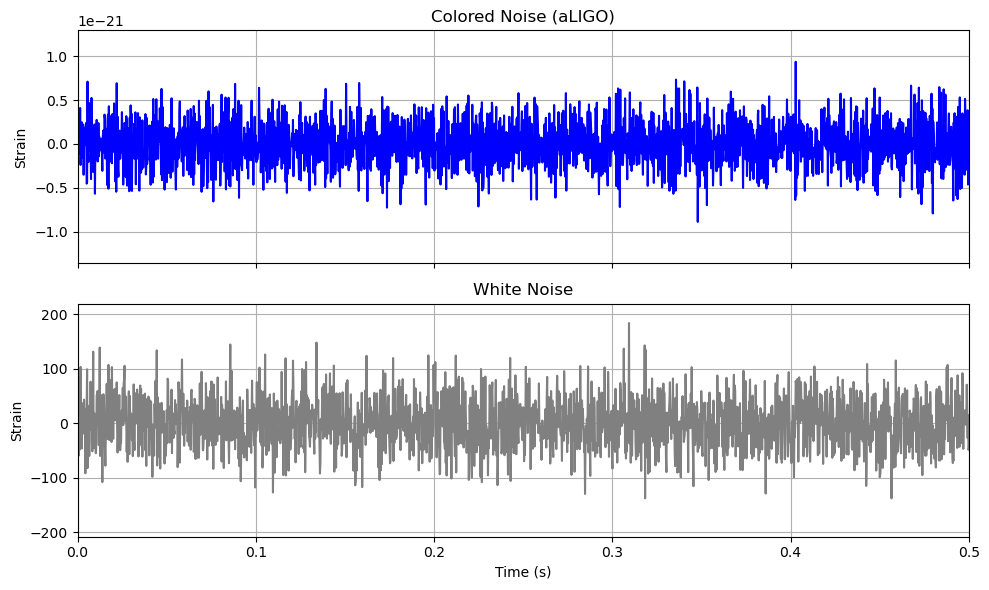

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axs[0].plot(ts_colored.sample_times, ts_colored, label='Colored Noise (aLIGO)', color='blue')
axs[0].set_ylabel('Strain')
axs[0].set_title('Colored Noise (aLIGO)')
axs[0].grid(True)
axs[0].set_xlim(0, 0.5)

axs[1].plot(ts_white.sample_times, ts_white, label='White Noise', color='gray')
axs[1].set_ylabel('Strain')
axs[1].set_title('White Noise')
axs[1].set_xlabel('Time (s)')
axs[1].grid(True)
axs[1].set_xlim(0, 0.5)

plt.tight_layout()
plt.show()

4. Gravitational Wave Signal Simulation (Time Domain)

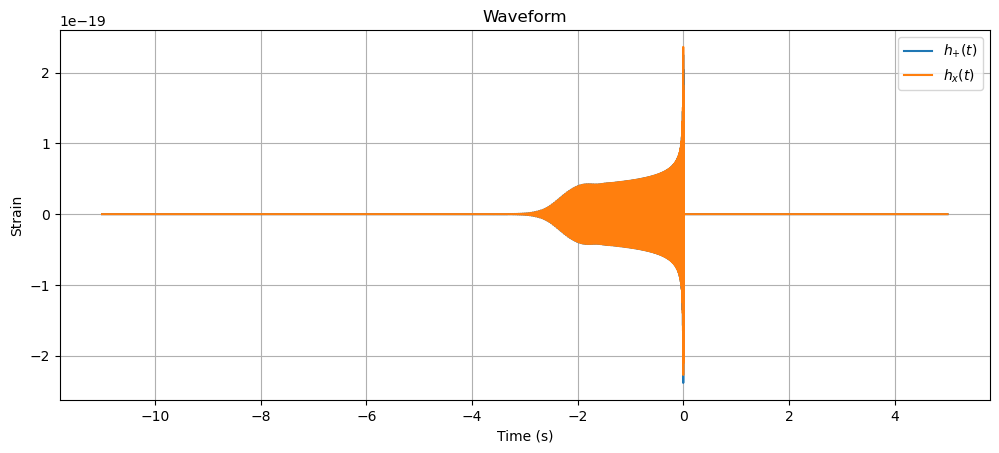

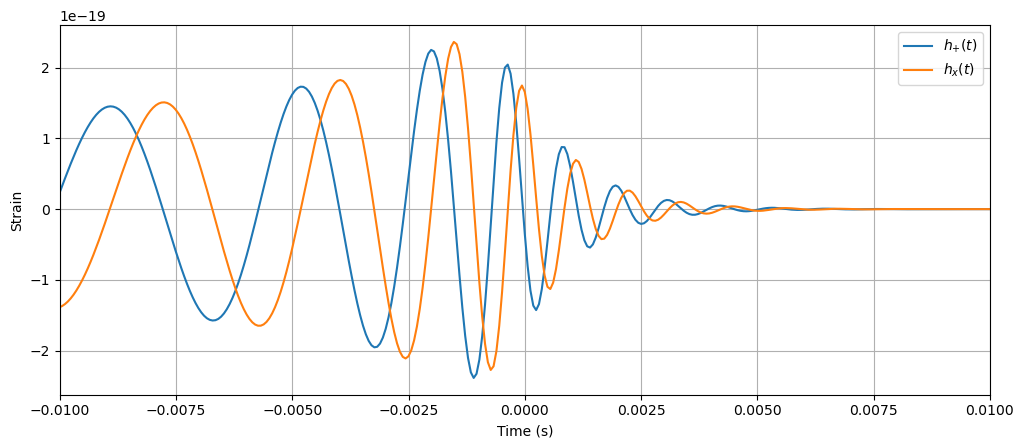

In [18]:

# Simulating a 10 + 10 solar mass Binary Black Hole (BBH)
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/16384,
                         f_lower=flow)

# Plotting the waveform polarizations
plt.figure(figsize=plt.figaspect(0.4))
plt.plot(hp.sample_times, hp, label=r'$h_{+}(t)$')
plt.plot(hp.sample_times, hc, label=r'$h_{x}(t)$')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.grid()
plt.title('Waveform')
plt.show()

# Zoom near the merger time
plt.figure(figsize=plt.figaspect(0.4))
plt.plot(hp.sample_times, hp, label=r'$h_{+}(t)$')
plt.plot(hp.sample_times, hc, label=r'$h_{x}(t)$')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.xlim(-.01, .01)
plt.legend()
plt.grid()
plt.show()

5. Final Combined Plot: Signal Amplitude vs. Noise Sensitivity (ASD)

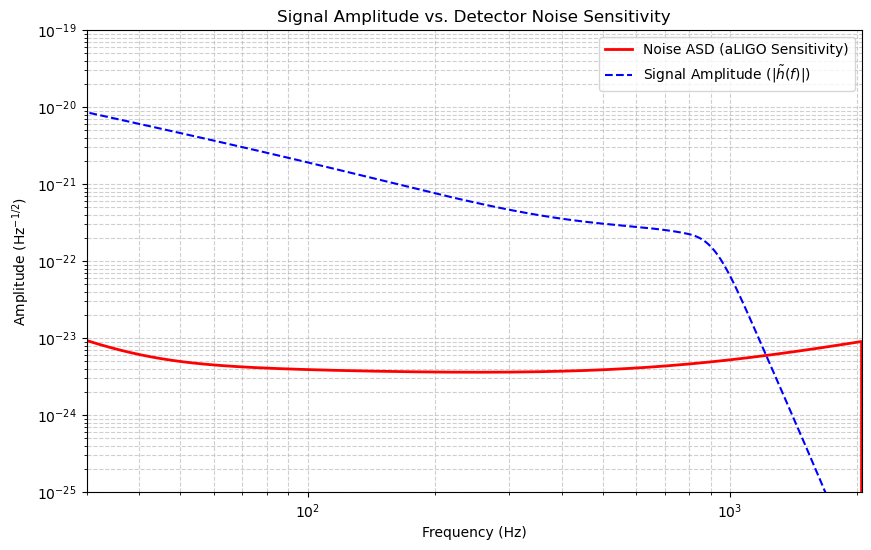

In [8]:
hp_fd, hc_fd = get_fd_waveform(approximant="IMRPhenomD",
                                 mass1=10,
                                 mass2=10,
                                 delta_t=1.0/16384,
                                 f_lower=flow,
                                 delta_f=delta_f)

# Noise ASD = sqrt(PSD)
# This is the detector's sensitivity curve.
ligo_asd = FrequencySeries(np.sqrt(psd.data), delta_f=psd.delta_f)

# Signal Amplitude = sqrt(|h_plus(f)|^2)
signal_amp = np.sqrt(hp_fd.squared_norm())


plt.figure(figsize=(10, 6))

# Noise Sensitivity Curve (ASD)
plt.loglog(ligo_asd.sample_frequencies, ligo_asd, 
           label='Noise ASD (aLIGO Sensitivity)', 
           color='red', 
           linewidth=2)

# Signal Amplitude
plt.loglog(hp_fd.sample_frequencies, signal_amp, 
           label=r'Signal Amplitude $(|\tilde{h}(f)|)$', 
           color='blue', 
           linestyle='--')

plt.title('Signal Amplitude vs. Detector Noise Sensitivity')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Amplitude (Hz$^{-1/2}$)')
plt.xlim(flow, sample_rate / 2)
plt.ylim(1e-25, 1e-19)
plt.grid(which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.show()